In [1]:
import os
import glob
import hydromt
import pyproj
import shapely
from hydromt import DataCatalog
import xarray as xr
import numpy as np
from os.path import join
import geopandas as gpd
import pandas as pd
from hydromt_sfincs import SfincsModel, utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors, patheffects
from string import ascii_lowercase as abcd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.ticker import FormatStrFormatter
import shapely

In [2]:
def get_compound_flood_extent(runs, da, name, value=1, write_tif=False):
    # Input runs as a list
    if len(runs) > 2:
        da_cmpd = da.sel(run=runs).sum(dim='run')
    else:
        da_cmpd = da.sel(run=runs)

    da_cmpd.name = name
    da_extent = xr.where(da_cmpd > 0, x=value, y=0)

    if write_tif is True:
        da_extent.raster.to_raster(f'{name}.tif', nodata=-9999.0)

    return da_extent

In [3]:
# Filepath to data catalogs yml
yml_BASE_Carolinas = r'Z:\Data-Expansion\users\lelise\data\data_catalog_BASE_Carolinas.yml'
root = r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\01_AGU2023\future_florence\future_florence_ensmean'
mod = SfincsModel(root=root, mode='r', data_libs=[yml_BASE_Carolinas])

In [4]:
# Directory to output stuff
work_dir = r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3'
os.chdir(work_dir)
fld_da_compound = xr.open_dataarray(os.path.join(os.getcwd(), 'process_attribution', 'pgw_compound_extent.nc'))
#fld_da_compound_ensmean = xr.open_dataarray(os.path.join(os.getcwd(), 'ensemble_mean', 'pgw_compound_extent_ensmean_mean.nc'))
#print(fld_da_compound_ensmean.sel(run='flor_fut_ensmean').data)

In [5]:
font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
mpl.rcParams.update({'axes.titlesize': 10})
mpl.rcParams["figure.autolayout"] = True
wkt = mod.grid['dep'].raster.crs.to_wkt()
utm_zone = mod.grid['dep'].raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
extent = np.array(mod.region.buffer(100).total_bounds)[[0, 2, 1, 3]]

In [6]:
# Organize the data for plotting
ds_plot = []
storms = ['flor', 'floy', 'matt']
for storm in storms:
    # future Ensemble members
    run_ids = fld_da_compound.run.to_numpy().tolist()
    storm_runs = [i for i in run_ids if f'{storm}' in i]
    storm_runs.remove(f'{storm}_pres')
    ds_all = fld_da_compound.sel(run=storm_runs).sum(dim='run')
    ds_all.name = f'{storm}_fut_members'

    # Future all extent
    #ds_ensmean_fut = xr.where(fld_da_compound_ensmean.sel(run=f'{storm}_fut_ensmean') > 0, 3, 0)
    ds_ensmean_fut = xr.where(ds_all > 1, 3, 0)

    # Present
    runs = [f'{storm}_pres']
    ds = fld_da_compound.sel(run=runs).sum(dim='run')
    ds.name = f'{storm}_pres'
    ds_ensmean_pres = get_compound_flood_extent(runs=runs, da=fld_da_compound, value=1,
                                                name=ds.name, write_tif=False)

    # diff == 3 is compound in the future only, 
    # diff == 2 is compound in the future and present
    # diff == 1 is compound in the present only
    diff = (ds_ensmean_fut - ds_ensmean_pres[0]).compute()
    diff = xr.where(diff == -1, 1, diff)
    diff.name = f'{storm}_fut_minus_pres_ensmean_{type}'

    ds_plot.append(diff)
    ds_plot.append(ds_all)

In [7]:
# Load layers - run once because it takes a while...
coastal_wb = mod.data_catalog.get_geodataframe('carolinas_coastal_wb')
coastal_wb = coastal_wb.to_crs(mod.crs)
coastal_wb_clip = coastal_wb.clip(mod.region)

major_rivers = mod.data_catalog.get_geodataframe('carolinas_nhd_area_rivers')
major_rivers = major_rivers.to_crs(mod.crs)
major_rivers_clip = major_rivers.clip(mod.region)

nc_major_rivers = mod.data_catalog.get_geodataframe('carolinas_major_rivers')
nc_major_rivers = nc_major_rivers.to_crs(mod.crs)
nc_major_rivers_clip = nc_major_rivers.clip(mod.region)

# basins = mod.data_catalog.get_geodataframe(
#     r'Z:\users\lelise\geospatial\hydrography\nhd\NHD_H_North_Carolina_State_Shape\Shape\WBDHU10.shp',
#     bbox=mod.region.to_crs(4326).total_bounds)
# basins = basins.to_crs(mod.crs)
# zoom_newport = basins[basins['Name'] == 'Newport River'].buffer(3000).total_bounds

In [8]:
row_names = ['Florence', 'Floyd', 'Matthew']
tick_labels = [['Present', 'Both', 'Future']]
nrow = 3
ncol = 2
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)


# Bbox needs to be in the same units as the model
# Try # http://bboxfinder.com

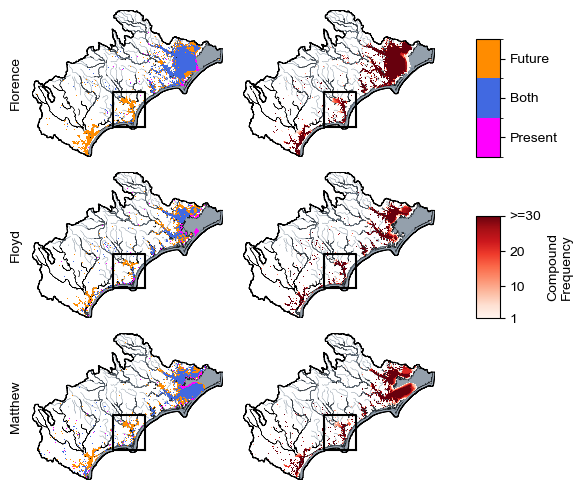

In [9]:
# Plot the Entire Domain 

# This outlines the subset image
extent = [730599.1620,3745648.4726,809931.1997,3832420.8957]
polygon = shapely.geometry.box(*extent)

# Now PLOT
figsize = (4.75, 5)
fig, axes = plt.subplots(nrows=nrow, ncols=ncol,
                         figsize=figsize,
                         subplot_kw={'projection': utm},
                         tight_layout=True)
axes = axes.flatten()
for i in range(len(axes)):
    ax = axes[i]
    dp = ds_plot[i]
    dp = dp.where(dp > 0)
    if i in last_in_row:
        cmap = 'Reds'
        norm = mpl.colors.Normalize(vmin=1, vmax=30)
        cs1 = dp.plot(ax=ax, cmap=cmap, norm=norm, extend='neither', shading='auto',
                      add_colorbar=False, zorder=2, alpha=1)
    else:
        cmap = mpl.colors.ListedColormap(['magenta', 'royalblue', 'darkorange'])
        bounds = [1, 2, 3, 4]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='neither')
        cs = dp.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, zorder=2, alpha=1)

for ax in axes:
    ax.set_title('')
    ax.set_aspect('equal')
    ax.set_axis_off()
    major_rivers_clip.plot(ax=ax, color='slategrey', edgecolor='black', linewidth=0.25, zorder=0, alpha=1)
    nc_major_rivers_clip.plot(ax=ax, color='slategrey', edgecolor='black', linewidth=0.25, zorder=0, alpha=1)
    coastal_wb_clip.plot(ax=ax, color='slategrey', edgecolor='black', linewidth=0.25, zorder=0, alpha=0.75)
    ax.plot(*polygon.exterior.xy, color='black', linewidth=1.5, zorder=3, alpha=1)
    mod.region.plot(ax=ax, color='none', edgecolor='black', linewidth=0.75, zorder=3, alpha=1)

for kk in range(nrow):
    axes[first_in_row[kk]].text(-0.05, 0.5, row_names[kk],
                                horizontalalignment='right',
                                verticalalignment='center',
                                rotation='vertical',
                                transform=axes[first_in_row[kk]].transAxes)
    pos0 = axes[last_in_row[kk]].get_position()  # get the original position
    if kk == 1:
        cax1 = fig.add_axes([pos0.x1 + 0.1, pos0.y0, 0.05, pos0.height * 0.7])
        cbar1 = fig.colorbar(cs1,
                             cax=cax1,
                             orientation='vertical',
                             ticks=[1, 10, 20, 30],
                             label='Compound\nFrequency'
                             )
        cbar1.ax.set_yticklabels(labels=['1', '10', '20', '>=30'])
    if kk == 0:
        cax = fig.add_axes([pos0.x1 + 0.1, pos0.y0, 0.05, pos0.height * 0.8])
        cbar = fig.colorbar(cs,
                            cax=cax,
                            orientation='vertical',
                            extend='neither',
                            ticks=[1.5, 2.5, 3.5])
        cbar.ax.set_yticklabels(labels=tick_labels[kk])

plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
plt.savefig(fr'compound_extent_FutMaxofEnsemble.jpg', dpi=300, bbox_inches="tight")
#plt.close()

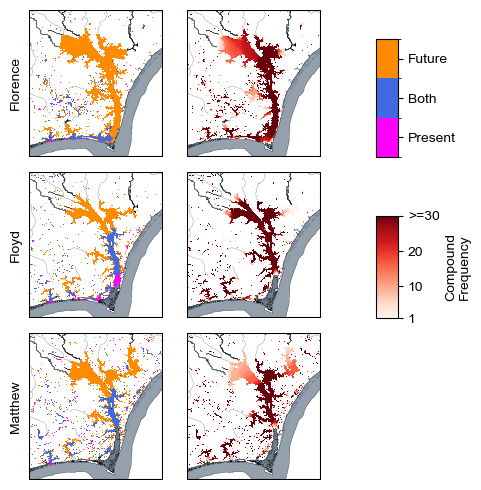

In [10]:
# Wilmington
# Plot the Entire Domain 
extent = [730599.1620,3745648.4726,809931.1997,3832420.8957]
figsize = (4.5, 5)
fig, axes = plt.subplots(nrows=nrow, ncols=ncol,
                         figsize=figsize,
                         subplot_kw={'projection': utm},
                         tight_layout=True)
axes = axes.flatten()
for i in range(len(axes)):
    ax = axes[i]
    dp = ds_plot[i]
    dp = dp.where(dp > 0)
    if i in last_in_row:
        cmap = 'Reds'
        norm = mpl.colors.Normalize(vmin=1, vmax=30)
        cs1 = dp.plot(ax=ax, cmap=cmap, norm=norm, extend='neither', shading='auto',
                      add_colorbar=False, zorder=2, alpha=1)
    else:
        cmap = mpl.colors.ListedColormap(['magenta', 'royalblue', 'darkorange'])
        bounds = [1, 2, 3, 4]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='neither')
        cs = dp.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, zorder=2, alpha=1)

for ax in axes:
    ax.set_title('')
    ax.set_aspect('equal')
    ax.set_axis_off()
    major_rivers_clip.plot(ax=ax, color='slategrey', edgecolor='black', linewidth=0.25, zorder=0, alpha=1)
    nc_major_rivers_clip.plot(ax=ax, color='slategrey', edgecolor='black', linewidth=0.25, zorder=0, alpha=1)
    coastal_wb_clip.plot(ax=ax, color='slategrey', edgecolor='black', linewidth=0.25, zorder=0, alpha=0.75)
    ax.plot(*polygon.exterior.xy, color='black', linewidth=1.5, zorder=3, alpha=1)
    #mod.region.plot(ax=ax, color='none', edgecolor='black', linewidth=0.75, zorder=3, alpha=1)
    minx, miny, maxx, maxy = extent
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    
for kk in range(nrow):
    axes[first_in_row[kk]].text(-0.05, 0.5, row_names[kk],
                                horizontalalignment='right',
                                verticalalignment='center',
                                rotation='vertical',
                                transform=axes[first_in_row[kk]].transAxes)
    pos0 = axes[last_in_row[kk]].get_position()  # get the original position
    if kk == 1:
        cax1 = fig.add_axes([pos0.x1 + 0.1, pos0.y0, 0.05, pos0.height * 0.7])
        cbar1 = fig.colorbar(cs1,
                             cax=cax1,
                             orientation='vertical',
                             ticks=[1, 10, 20, 30],
                             label='Compound\nFrequency'
                             )
        cbar1.ax.set_yticklabels(labels=['1', '10', '20', '>=30'])
    if kk == 0:
        cax = fig.add_axes([pos0.x1 + 0.1, pos0.y0, 0.05, pos0.height * 0.8])
        cbar = fig.colorbar(cs,
                            cax=cax,
                            orientation='vertical',
                            extend='neither',
                            ticks=[1.5, 2.5, 3.5])
        cbar.ax.set_yticklabels(labels=tick_labels[kk])

plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
plt.savefig(fr'compound_extent_FutMaxofEnsemble_Wilmington.jpg', dpi=300, bbox_inches="tight")
#plt.close()